# 서울시 평균 기온 예측 Baseline

평가지표 : MAE (mean absolute error)

## 진행 순서
1. 라이브러리 및 데이터셋 불러오기
2. EDA
   1. 데이터타입 확인
   2. 인사이트 정리하기  <br>  
3. 전처리(Preprocessing)
   1. train/validation split  
   2. 결측값 처리
   3. 인코딩(LabelEncoding or dummy) - object type에 대해서 원핫인코딩 or 라벨인코딩
   4. 스케일링 - Standard Scaler / MinMaxScaler
4. 모델링
   1. 모델 선정 
      - 머신러닝 모델 - 랜덤포레스트, SVM, LightGBM, XGBoost, Catboost 등
      - 딥 러닝 모델 - LSTM, CNN-LSTM, GRU 등
      - 고전 모델 - ARIMA, Linear Regression 등.
   2. 하이퍼파라미터 튜닝 (Optuna, gridsearch)
   3. 앙상블 (Ensemble)
5. 검증 및 결과도출
   1. 교차검증(Cross Validation)
   2. pd.DataFrame.to_csv()

### 1. 라이브러리 및 데이터셋 불러오기

In [79]:
###  1. 라이브러리 및 데이터셋 불러오기

# 기본적인 라이브러리 불러오기 
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# EDA 및 시각화를 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error


In [80]:
### 2. 데이터셋 불러오기
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/sample_submission.csv')

In [81]:
train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


In [82]:
# 컬럼 수 11, 레이블 수 23011
train.shape

(23011, 11)

In [83]:
# 60년도부터 2023년도 까지의 데이터인듯 싶다.
# 충분한 양이 쌓여있으니 해보긴 편하지 않을까?
test.head()

,일시,평균기온
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0


In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일시      358 non-null    object
 1   평균기온    358 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


## 2. EDA

- info
- describe
- isna().sum()

### 1) EDA - info
####  Column별 설명
> 일시 : Datetime  
> 최고기온 : max temperatures  
> 최저기온 : min temperatures  
> 일교차 : max - min  
> 강수량 : rainfalls  
> 평균습도 : mean humidity  
> 평균풍속 : mean wind speed  
> 일조합 : the amount of sunshine (태양광선이 구름이나 안개로 가려지지 않고 실제로 땅 위를 비추는 양) - 시간의 개념(hr)  
> 일사합 : the amount of insolation (지표에 도달하는 태양에너지의 합) - (MJ/m2)  
> 일조율 : rate of sunshine (일조시간 / 가조시간) - 일출부터 일몰까지 중 일조시간의 비율  
> 평균기온 : mean temperatures (`Target value`)

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [103]:
# 일시가 object type인데, 이걸 먼저 datetime으로 바꿔주자.
train['일시'] = pd.to_datetime(train['일시'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일시      23011 non-null  datetime64[ns]
 1   최고기온    23011 non-null  float64       
 2   최저기온    23011 non-null  float64       
 3   일교차     23011 non-null  float64       
 4   강수량     23011 non-null  float64       
 5   평균습도    23011 non-null  float64       
 6   평균풍속    23011 non-null  float64       
 7   일조합     23011 non-null  float64       
 8   일사합     23011 non-null  float64       
 9   일조율     23011 non-null  float64       
 10  평균기온    23011 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.9 MB


### 2) EDA - fill null value

In [87]:
# 결측치 확인
train.isna().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

In [88]:
# 각각 결측치 비율이 어떻게 되는지 확인하기.
train.isna().sum() / train.shape[0]

일시      0.000000
최고기온    0.000130
최저기온    0.000130
일교차     0.000174
강수량     0.602364
평균습도    0.000000
평균풍속    0.000174
일조합     0.005128
일사합     0.211290
일조율     0.015905
평균기온    0.000000
dtype: float64

In [89]:
# 일교차를 찾아보니, 최고기온 or 최저기온 한 쪽이 빵꾸나있는 케이스이다.
train.loc[train['일교차'].isna()]

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
2606,1967-02-19,NaN,NaN,NaN,NaN,62.0,1.8,9.5,NaN,93.1,-1.7
5037,1973-10-16,NaN,NaN,NaN,0.4,74.0,1.8,3.5,9.24,29.7,12.3
21104,2017-10-12,NaN,8.8,NaN,NaN,71.0,2.0,NaN,2.23,0.0,11.4
22865,2022-08-08,28.4,NaN,NaN,129.6,91.6,3.3,NaN,NaN,0.0,26.8


- 강수량의 결측치는 상당히 많다. (하지만 비가 오지 않는 날인 경우도 NaN으로 표시되었을 수 있다.)
- 최고기온, 최저기온, 일교차 ==> 기온 한 쪽이 Nan값인 경우, 일교차 역시 NaN값일 가능성이 매우 높다.
- 평균풍속 역시 매우 적은 결측값이 존재한다.
- 일조합, 일조율, 일사합은 애매하게 존재한다.

---
기본적인 결측치 제거 방법
1. 시계열 데이터의 특성상 뒷단의 데이터를 따라 갈 확률이 높다.
   - 먼저 bfill로 먼저 다 채우고, 그 다음 ffill로 나머지값을 채우기
2. 변수간의 상관관계를 구해서 regression 진행하기(ex. `평균풍속`)
3. 결측치를 모두 0으로 채워서 해버리거나, 결측값이 너무 많은 컬럼을 제거하는 방식으로도 진행해보기

In [90]:
# 1번 방법으로 먼저 진행해보자.
train = train.fillna(method='bfill').fillna(method='ffill')
train.isna().sum()


일시      0
최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

In [91]:
train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,0.4,68.3,1.7,6.7,4.81,28.1,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,4.81,28.1,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,4.81,28.1,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,4.81,28.1,7.5
4,1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,4.81,28.1,-4.6


In [92]:
train.describe()

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
count,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000,23011.000000
mean,17.071257,8.452001,8.619291,7.395932,65.202851,2.380900,5.857694,10.432268,48.326613,12.415419
std,10.714039,10.578244,2.907101,17.261952,14.549077,0.947545,3.815408,6.402752,31.514588,10.489515
min,-13.600000,-20.200000,1.000000,0.000000,17.900000,0.100000,0.000000,0.000000,0.000000,-16.400000
25%,7.800000,-0.300000,6.600000,0.000000,54.900000,1.700000,2.200000,4.810000,18.600000,3.400000
50%,18.900000,9.200000,8.600000,1.000000,65.500000,2.200000,6.600000,9.020000,54.700000,13.800000
75%,26.400000,17.900000,10.600000,6.500000,75.800000,2.900000,9.000000,15.040000,77.750000,21.800000
max,39.600000,30.300000,19.600000,332.800000,99.800000,7.800000,13.700000,33.480000,96.900000,33.700000


In [93]:
# 결국 평균기온을 예측하는 것이고, 상관관계는 아래와 같다.
abs(train.corr(method='pearson')['평균기온']).sort_values(ascending=False)[1:]

최고기온    0.989547
최저기온    0.989342
평균습도    0.376363
일사합     0.297970
강수량     0.236198
일조율     0.215494
평균풍속    0.208948
일교차     0.046929
일조합     0.031529
Name: 평균기온, dtype: float64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


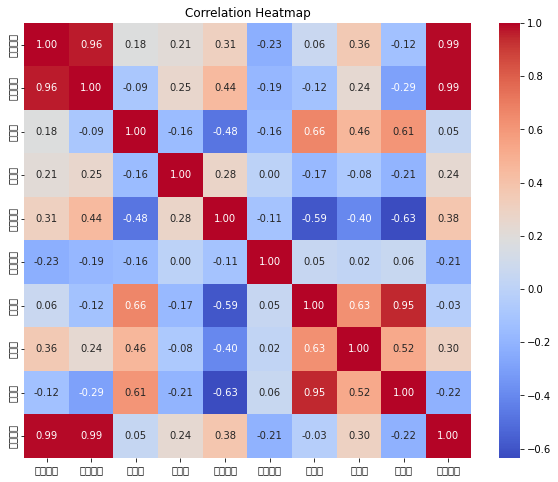

In [97]:
# 이렇게 봤을 때, 변수들간의 상관관계가 높은 경우 vif값이 높고, 다중공선성으로 인해 좋지 않은 결과물이 나올 수 있다.
correlation_matrix = train.corr()

# 히트맵으로 상관관계 표현하기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [98]:
correlation_matrix

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
최고기온,1.000000,0.962803,0.182041,0.209029,0.306830,-0.227211,0.063482,0.357785,-0.124456,0.989547
최저기온,0.962803,1.000000,-0.090414,0.254528,0.442909,-0.185452,-0.118256,0.236629,-0.293485,0.989342
일교차,0.182041,-0.090414,1.000000,-0.156012,-0.480863,-0.162607,0.664347,0.457556,0.609225,0.046929
강수량,0.209029,0.254528,-0.156012,1.000000,0.276768,0.002506,-0.174433,-0.076811,-0.206311,0.236198
평균습도,0.306830,0.442909,-0.480863,0.276768,1.000000,-0.111823,-0.591154,-0.404168,-0.634528,0.376363
평균풍속,-0.227211,-0.185452,-0.162607,0.002506,-0.111823,1.000000,0.054293,0.023778,0.059475,-0.208948
일조합,0.063482,-0.118256,0.664347,-0.174433,-0.591154,0.054293,1.000000,0.626656,0.947544,-0.031529
일사합,0.357785,0.236629,0.457556,-0.076811,-0.404168,0.023778,0.626656,1.000000,0.521442,0.297970
일조율,-0.124456,-0.293485,0.609225,-0.206311,-0.634528,0.059475,0.947544,0.521442,1.000000,-0.215494
평균기온,0.989547,0.989342,0.046929,0.236198,0.376363,-0.208948,-0.031529,0.297970,-0.215494,1.000000


In [99]:
# 자기 자신을 제외하고, 어느 상관계수와 가장 높은지를 확인해보자.
abs(train.corr(method='pearson')['평균습도']).sort_values(ascending=False)[1:]

일조율     0.634528
일조합     0.591154
일교차     0.480863
최저기온    0.442909
일사합     0.404168
평균기온    0.376363
최고기온    0.306830
강수량     0.276768
평균풍속    0.111823
Name: 평균습도, dtype: float64

In [102]:
# 변수들간의 상관관계간 너무 높은 경우, 다중공선성으로 인해 제대로된 결과가 나오지 않을 수 있다.
# 아래 vif를 사용하여 다중공선성을 확인하고, vif값이 10보다 높은 경우, 변수들을 제거하거나 pca로 합쳐서 사용할 계획이다.

# 다중공선성 확인을 위한 vif 체크
from statsmodels.stats.outliers_influence import variance_inflation_factor 

variance_inflation_factor(correlation_matrix)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices